In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from scipy import optimize
from bioinfokit.analys import stat
import statsmodels.api as sm
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import kruskal

#### Ler dados do dataframe

In [2]:
cols = ['NumeroFatura', 'CodigoProduto', 'Descricao',
        'Quantidade', 'DataFatura', 'PrecoUnitario',
        'IDCliente', 'Pais']
# Ler arquivoa CSV
# df1 = pd.read_csv('ano_2009-2010.csv', encoding='latin1')
df = pd.read_csv('ano_2010-2011.csv', encoding='latin1')

# Concatenar os dois DataFrames
# df = pd.concat([df1, df2], ignore_index=True)
df.columns = cols

# Imprimir o DataFrame resultante
df

,NumeroFatura,CodigoProduto,Descricao,Quantidade,DataFatura,PrecoUnitario,IDCliente,Pais
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


#### Realiza limpeza dos dados

In [3]:
# Exclui todas faturas canceladas
df = df[~df['NumeroFatura'].str.startswith(('C', 'c'))]

# Exclui linhas que tenham valor e quantidades menores ou igual a zero
df = df[df["Quantidade"] > 0]
df = df[df["PrecoUnitario"] > 0.0]

df

,NumeroFatura,CodigoProduto,Descricao,Quantidade,DataFatura,PrecoUnitario,IDCliente,Pais
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


#### Gera Dataframe com agrupamento

In [4]:
# cols_to_group = ['CodigoProduto', 'Pais']
cols_to_group = ['Pais']
df_final = df.groupby(cols_to_group).agg({"Quantidade": "mean", "PrecoUnitario": "mean"})
df_final = df_final.reset_index()
df_final = df_final.dropna()
df_final

,CodigoProduto,Pais,Quantidade,PrecoUnitario
0,10002,EIRE,12.000000,0.850000
1,10002,France,46.500000,0.850000
2,10002,Germany,1.000000,0.850000
3,10002,Japan,1.000000,0.850000
4,10002,Spain,24.000000,0.850000
...,...,...,...,...
19653,gift_0001_20,United Kingdom,1.111111,16.708889
19654,gift_0001_30,United Kingdom,1.000000,25.075714
19655,gift_0001_40,United Kingdom,1.000000,33.566667
19656,gift_0001_50,United Kingdom,1.000000,41.890000


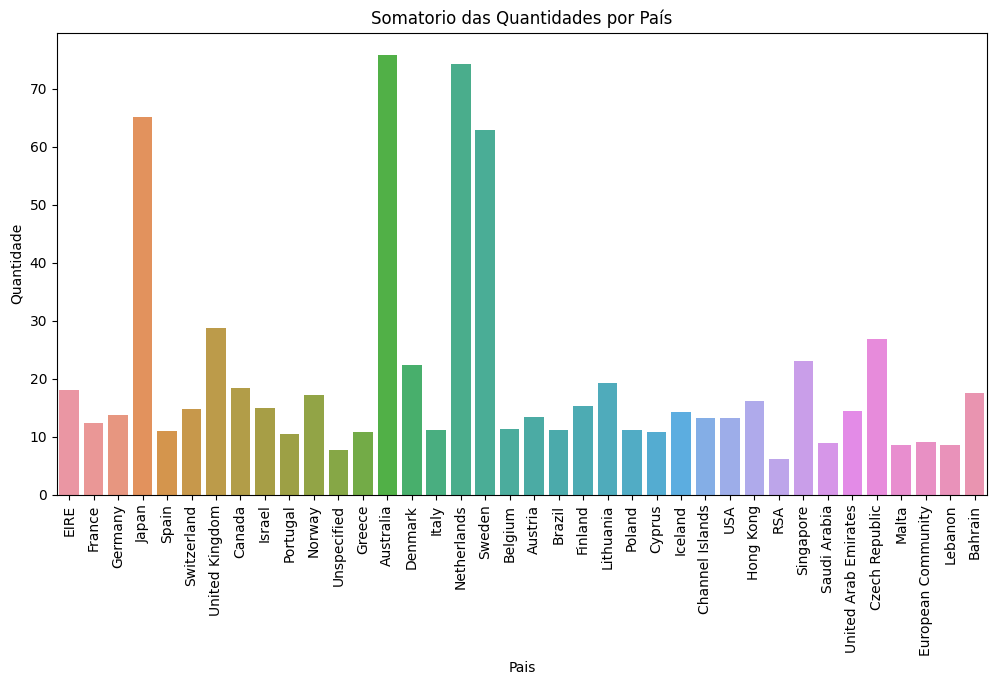

In [5]:
# Gráfico de barras para comparar o somat´0rio das quantidades entre os países
plt.figure(figsize=(12, 6))
sns.barplot(x='Pais', y='Quantidade', data=df_final, errorbar=None)
plt.xticks(rotation=90)
plt.title('Somatorio das Quantidades por País')
plt.show()

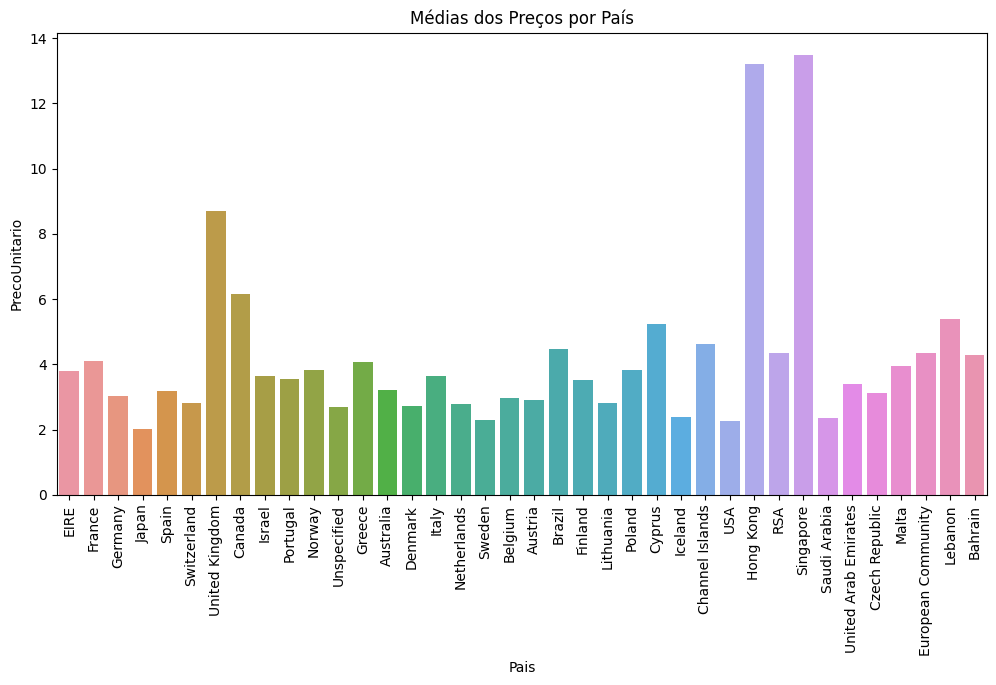

In [6]:
# Gráfico de barras para comparar as médias dos preços entre os países
plt.figure(figsize=(12, 6))
sns.barplot(x='Pais', y='PrecoUnitario', data=df_final, errorbar=None)
plt.xticks(rotation=90)
plt.title('Médias dos Preços por País')
plt.show()

#### Aferindo Normalidade

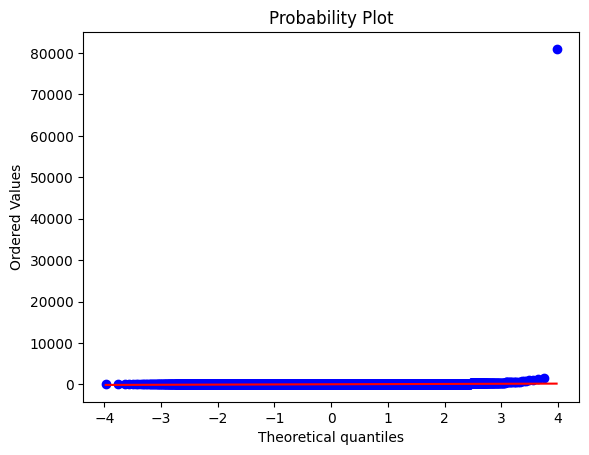

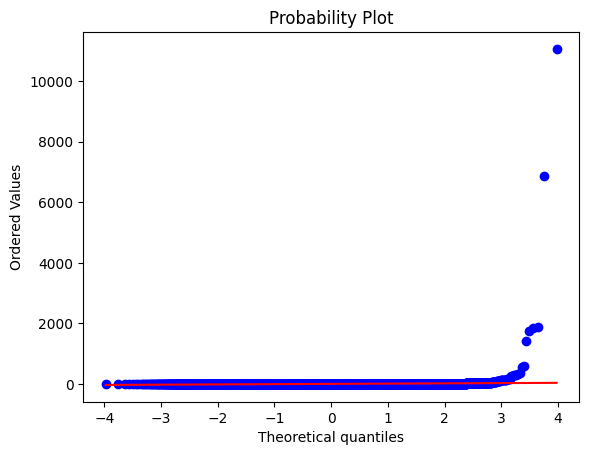

In [7]:
stats.probplot(df_final["Quantidade"], dist="norm", plot=plt)
plt.show()
stats.probplot(df_final["PrecoUnitario"], dist="norm", plot=plt)
plt.show()


#### Prepara para aferição teste ANOVA

In [8]:
df_melt = pd.melt(df_final.drop(cols_to_group, axis=1))
df_melt

,variable,value
0,Quantidade,12.000000
1,Quantidade,46.500000
2,Quantidade,1.000000
3,Quantidade,1.000000
4,Quantidade,24.000000
...,...,...
39311,PrecoUnitario,16.708889
39312,PrecoUnitario,25.075714
39313,PrecoUnitario,33.566667
39314,PrecoUnitario,41.890000


In [9]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ variable', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
variable,3.040423e+06,1.0,17.654261,0.000027
Residual,6.770670e+09,39314.0,NaN,NaN


In [10]:
res = stat()
res.anova_stat(df_melt, res_var='value', anova_model='value ~ variable')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
variable,1.0,3.040423e+06,3.040423e+06,17.654261,0.000027
Residual,39314.0,6.770670e+09,1.722203e+05,NaN,NaN


In [11]:
df_melt['variable'] = df_melt['variable'].replace('Quantidade', '1')
df_melt['variable'] = df_melt['variable'].replace('PrecoUnitario', '2')
df_melt['variable'].unique()

array(['1', '2'], dtype=object)

In [12]:
res = stat()
res.tukey_hsd(df_melt, res_var='value', xfac_var='variable', anova_model='value ~ variable')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,1,2,17.587832,9.383391,25.792274,5.942097,0.001


#### Avaliação dos residuos

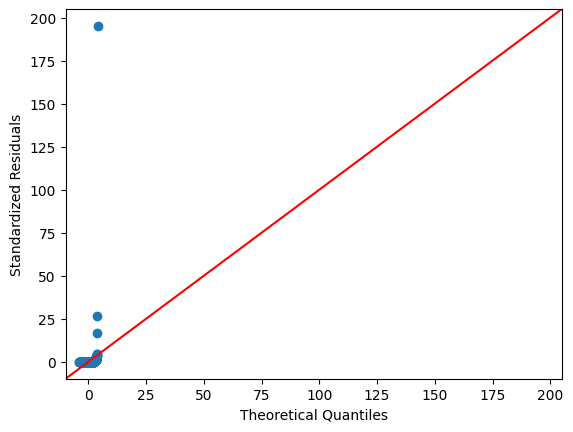

In [13]:
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

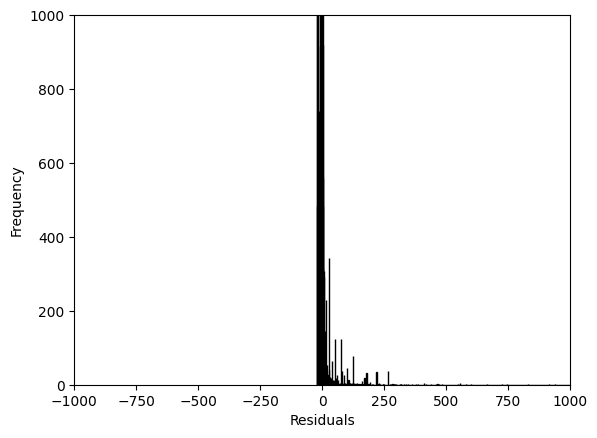

In [14]:
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.xlim(-1000, 1000)
plt.ylim(0, 1000)
plt.show()

In [15]:
w, pvalue = stats.shapiro(model.resid)
print('Statistics= %.3f, pvalue=%.3f' % (w, pvalue))
# interpret
alpha = 0.05
if pvalue > alpha:
	print('Resíduo com Distribuição Normal (Não rejeita H0)')
else:
	print('Diferente da Normal (rejeita H0)')

Statistics= 0.004, pvalue=0.000
Diferente da Normal (rejeita H0)


/home/fgaraujofh/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [16]:
from scipy import stats

# perform the Kolmogorov-Smirnov test on the residuals
k_statistic, pvalue = stats.kstest(model.resid, 'norm')

# print the results and interpret
alpha = 0.05
if pvalue > alpha:
    print('Resíduo com Distribuição Normal (Não rejeita H0)')
else:
    print('Diferente da Normal (rejeita H0)')

print('K-S Statistic= %.3f, pvalue=%.3f' % (k_statistic, pvalue))

Diferente da Normal (rejeita H0)
K-S Statistic= 0.699, pvalue=0.000


In [17]:
w, pvalue = stats.bartlett(df_final['Quantidade'], df_final['PrecoUnitario'])
print('Statistics= %.3f, pvalue=%.3f' % (w, pvalue))
# interpret
alpha = 0.05
if pvalue > alpha:
	print('Same Variance (Não rejeita H0)')
else:
	print('Different Variance (rejeita H0)')

Statistics= 44220.785, pvalue=0.000
Different Variance (rejeita H0)


In [18]:
res = stat()
res.bartlett(df_melt, res_var='value', xfac_var='variable')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),44220.7846
1,Degrees of freedom (Df),1.0000
2,p value,0.0000


#### Não paramétrico Testes -> Mann-Whitney U Test

In [19]:
stats, p = mannwhitneyu(df_final['Quantidade'], df_final['PrecoUnitario'])
print('Statistics= %.3f, p=%.3f' % (stats, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (Não rejeita H0)')
else:
	print('Different distribution (rejeita H0)')

Statistics= 327847355.000, p=0.000
Different distribution (rejeita H0)


In [20]:
stats, p = wilcoxon(df_final['Quantidade'], df_final['PrecoUnitario'])
print('Statistics= %.3f, p=%.3f' % (stats, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (Não rejeita H0)')
else:
	print('Different distribution (rejeita H0)')

Statistics= 25414717.000, p=0.000
Different distribution (rejeita H0)
